# 0. Attaching libraries

In [20]:
import os
import sqlite3
import pandas as pd
import sys
#from ydata_profiling import ProfileReport # for profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")       # optional aesthetics
%matplotlib inline 

In [21]:
from dateutil.relativedelta import relativedelta
import builtins

In [22]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

In [23]:
from sklearn.decomposition import PCA

# 1. Reading the core Dataset from the golden source

In [24]:
data_path = r"C:\Users\dimet\OneDrive - NOVAIMS\NOVA IMS BDMWDS\0 Data"
csv_name  = "Dataset.csv"
csv_file  = os.path.join(data_path, csv_name)
excel_path  = (r"C:\Users\dimet\OneDrive - NOVAIMS\NOVA IMS BDMWDS"
               r"\3 Databook\Source_data_Conversion.xlsx")
# ── Load the CSV into a DataFrame ──────────────────────────────────────────
df = pd.read_csv(csv_file, low_memory=False)

In [25]:
# Quick sanity check (optional)
print(df.shape)       # prints (rows, columns)

(9373, 78)


## NEW COLUMNS

In [26]:
df["customer_id"] = df[["zipcode_link", "zip4", "place_residence","birth_date", "gender"]].astype(str).agg("-".join, axis=1)

In [27]:
# 1. Build boolean conditions based on == "Y"
conditions = [
    df['wa'] == 'Y',
    df['wa_bep_ca'] == 'Y',
    df['wa_ca'] == 'Y'
]

# 2. Corresponding labels
choices = ['1. Only liability insurance', '2. Liability + limited casco', '3. Liability + full casco']

# 3. Create the new column, defaulting to NaN if none of the three has "Y"
df['coverage_type'] = np.select(conditions, choices, default=np.nan)

In [28]:
# ── 1. External “today” reference ───────────────────────────────────────────
current_date = pd.to_datetime("2019-11-01")    # ← use any value you like
fancy_date = current_date.strftime("%B %d %Y")

In [29]:
# ── 2. Parse birth_date & compute age ───────────────────────────────────────
# 2-a. Ensure birth_date is a datetime column
df["birth_date"] = pd.to_datetime(df["birth_date"], errors="coerce")

# 2-b. Convert to integer years using dateutil.relativedelta for accuracy
df["age"] = df["birth_date"].apply(
    lambda bd: relativedelta(current_date, bd).years if pd.notnull(bd) else pd.NA
)
# ── 1. Ensure age is numeric ────────────────────────────────────────────────
# (errors='coerce' converts any bad strings to NaN so they drop out later)
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# ── 2. Create age bands ─────────────────────────────────────────────────────
age_bins   = [0, 25, 35, 45, 55, 65, 120]               # tweak if needed
age_labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

In [30]:
df["age_band"] = pd.cut(df["age"],
                           bins=age_bins,
                           labels=age_labels,
                           right=False)

In [31]:
df["urb_norm"] = (
    df["URB"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"1": "1-VeryHigh", "2": "2-High", "3": "3-Mid-to-High", "4": "4-Mid", "5": "5-Mid-to-Low", "6": "6-Low","7": "7-VeryLow", "0": "Unknown", "N" : "Unknown"})
)

In [34]:
month_map = {
    "January":   "01",
    "February":  "02",
    "March":     "03",
    "April":     "04",
    "May":       "05",
    "June":      "06",
    "July":      "07",
    "August":    "08",
    "September": "09",
    "October":   "10",
    "November":  "11",
    "December":  "12"
}

df["buildmonth_num"] = df["buildmonth_car"].map(month_map)

In [35]:
# 2. Combine year + month + “01” (first of month) into a YYYY-MM-DD string and convert to datetime:
df["build_date"] = pd.to_datetime(
    df["buildyear_car"].astype(str).str[:4] + "-" + 
    df["buildmonth_num"] + "-01"
)

# Now 'build_date' holds a Timestamp for the first day of that month/year.
print(df[["buildyear_car", "buildmonth_car", "build_date"]].head())

   buildyear_car buildmonth_car build_date
0         2016.0           June 2016-06-01
1         2015.0           June 2015-06-01
2         2016.0          April 2016-04-01
3         2009.0           June 2009-06-01
4         2003.0        January 2003-01-01


In [36]:
# Calculate car_age
df['car_age'] = current_date.year - df['build_date'].dt.year - (
    (current_date.month < df['build_date'].dt.month) |
    ((current_date.month == df['build_date'].dt.month) & (current_date.day < df['build_date'].dt.day))
).astype(int)

In [37]:
# 1) Make sure `policy_start_date` is a datetime:
df['policy_start_date'] = pd.to_datetime(
    df['policy_start_date'],
    errors='coerce'
)

In [38]:
# Define age bins and labels
bins = [0, 3, 7, 11, 100]
labels = ['0-3', '4-7', '8-11', '12+']

# Create normalized age categories
df['car_age_norm'] = pd.cut(df['car_age'], bins=bins, labels=labels, include_lowest=True).cat.add_categories('Unknown').fillna("Unknown")


In [39]:
df

,affinity_name,status_report,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,date_offer,date_request,...,churn,customer_id,coverage_type,age,age_band,urb_norm,buildmonth_num,build_date,car_age,car_age_norm
0,Insuro,Requestwithdrawn,1000,10000.0,10000,2132,1985-01-01,HYUNDAI,2018-10-11,2018-10-11,...,1,10000-2132-nan-1985-01-01-nan,1. Only liability insurance,34.0,25–34,3-Mid-to-High,06,2016-06-01,3.0,0-3
1,other,Tailoredofferwithdrawn,1001,NaN,10001,6027,1987-04-01,AUDI,2018-10-11,NaN,...,-1,10001-6027-nan-1987-04-01-nan,nan,32.0,25–34,7-VeryLow,06,2015-06-01,4.0,4-7
2,other,Incompleterequest,1002,NaN,10002,3824,1972-11-01,VOLKSWAGEN,2018-10-11,NaN,...,-1,10002-3824-nan-1972-11-01-nan,3. Liability + full casco,47.0,45–54,2-High,04,2016-04-01,3.0,0-3
3,other,Policycreated,1003,10002.0,10003,6921,1983-08-01,MAZDA,2018-10-11,2018-10-11,...,1,10003-6921-nan-1983-08-01-nan,2. Liability + limited casco,36.0,35–44,4-Mid,06,2009-06-01,10.0,8-11
4,other,Policycreated,1004,10003.0,10004,8266,1990-04-01,VOLVO,2018-10-12,2018-10-12,...,1,10004-8266-nan-1990-04-01-nan,1. Only liability insurance,29.0,25–34,4-Mid,01,2003-01-01,16.0,12+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9368,other,Requestaccepted,9439,11946.0,15568,1161,1960-09-01,VOLKSWAGEN,2020-03-08,2020-03-08,...,-1,15568-1161-nan-1960-09-01-nan,3. Liability + full casco,59.0,55–64,6-Low,12,2011-12-01,7.0,4-7
9369,other,Waitforapproval,9440,11947.0,15582,5015,1953-04-01,NISSAN,2020-03-08,2020-03-08,...,-1,15582-5015-nan-1953-04-01-nan,3. Liability + full casco,66.0,65+,2-High,02,2017-02-01,2.0,0-3
9370,Insuro,Tailoredofferrequested,9441,NaN,10332,3078,1976-04-01,TOYOTA,2020-03-08,NaN,...,-1,10332-3078-nan-1976-04-01-nan,2. Liability + limited casco,43.0,35–44,1-VeryHigh,01,2004-01-01,15.0,12+
9371,T&B,Calculatenewpremium,9442,NaN,12968,1965,1951-07-01,TOYOTA,2020-03-08,NaN,...,-1,12968-1965-nan-1951-07-01-nan,2. Liability + limited casco,68.0,65+,4-Mid,09,2004-09-01,15.0,12+


## ANALYSIS

In [42]:
columns_to_keep = [
       "zip4", "PROVINCE", 'URB', 'INCOME', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD',
       'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED',
       'FAM_WCHILD_OLD', 'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR',
    "conv","churn"
       ]

In [43]:
df_sub = df[df["affinity_name"]=="T&B"][columns_to_keep].copy()

In [44]:
df_sub.head()

,zip4,PROVINCE,URB,INCOME,SOCCL_A,SOCCL_B1,SOCCL_B2,SOCCL_C,SOCCL_D,EDU_HIGH,...,FAM_WCHILD_Y,FAM_WCHILD_MED,FAM_WCHILD_OLD,CIT_HOUSEHOLD,LOAN,SAVINGS,SHOP_ONLINE,CAR,conv,churn
787,7582,Overijssel,5.0,2.0,3.0,4.0,2.0,1.0,2.0,3.0,...,1.0,3.0,4.0,5.0,1.0,5.0,6.0,5.0,0,-1
873,3221,South Holland,4.0,6.0,1.0,3.0,3.0,1.0,1.0,1.0,...,1.0,2.0,4.0,4.0,2.0,5.0,3.0,3.0,0,-1
952,4634,North Brabant,7.0,2.0,4.0,3.0,2.0,2.0,1.0,4.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,1,0
953,4634,North Brabant,7.0,2.0,4.0,3.0,2.0,2.0,1.0,4.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,0,-1
954,4634,North Brabant,7.0,2.0,4.0,3.0,2.0,2.0,1.0,4.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,0,-1


In [45]:
print(df_sub.isna().sum())

zip4                0
PROVINCE           21
URB                21
INCOME            198
SOCCL_A            36
SOCCL_B1           36
SOCCL_B2           36
SOCCL_C            36
SOCCL_D            36
EDU_HIGH           36
EDU_MID            36
EDU_LOW            36
DINK               36
OWN_HOUSE          37
AVG_HOUSE          61
STAGE_OF_LIFE      45
SINGLE             36
FAM                36
FAM_WCHILD         36
SINGLES_YOUNG      36
SINGLES_MID        36
SINGLES_OLD        36
FAM_CHILD_Y        36
FAM_CHILD_O        36
FAM_WCHILD_Y       36
FAM_WCHILD_MED     36
FAM_WCHILD_OLD     36
CIT_HOUSEHOLD      36
LOAN               36
SAVINGS            36
SHOP_ONLINE        36
CAR                36
conv                0
churn               0
dtype: int64


In [46]:
mode_income = (
    df_sub
    .groupby('zip4')['INCOME']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income')
)

# 2. Merge the mode back into the original DataFrame
df_sub = df_sub.merge(mode_income, left_on='zip4', right_index=True)

# 3. Impute missing INCOME values using the mode for that zip4
df_sub['INCOME_filled'] = df_sub['INCOME'].fillna(df_sub['mode_income'])

# 4. (Optional) Drop the helper column if you no longer need it
df_sub.drop(columns=['mode_income'], inplace=True)

In [47]:
# 2. Second imputation: For any remaining NaNs in INCOME, use PROVINCE-level mode
#    - Compute mode income per PROVINCE based on the “INCOME_imputed_zip4” column
mode_income_prov = (
    df_sub
    .groupby('PROVINCE')['INCOME_filled']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income_prov')
)

# Merge and fill any remaining NaNs based on province mode
df_sub = df_sub.merge(mode_income_prov, left_on='PROVINCE', right_index=True)
df_sub['INCOME_final'] = df_sub['INCOME_filled'].fillna(df_sub['mode_income_prov'])

# Drop helper columns if desired
df_sub.drop(columns=["INCOME", 'INCOME_filled', 'mode_income_prov'], inplace=True)

In [48]:
df_sub.dropna(axis=0, how='any', inplace=True)

In [49]:
print(df_sub.isna().sum())

zip4              0
PROVINCE          0
URB               0
SOCCL_A           0
SOCCL_B1          0
SOCCL_B2          0
SOCCL_C           0
SOCCL_D           0
EDU_HIGH          0
EDU_MID           0
EDU_LOW           0
DINK              0
OWN_HOUSE         0
AVG_HOUSE         0
STAGE_OF_LIFE     0
SINGLE            0
FAM               0
FAM_WCHILD        0
SINGLES_YOUNG     0
SINGLES_MID       0
SINGLES_OLD       0
FAM_CHILD_Y       0
FAM_CHILD_O       0
FAM_WCHILD_Y      0
FAM_WCHILD_MED    0
FAM_WCHILD_OLD    0
CIT_HOUSEHOLD     0
LOAN              0
SAVINGS           0
SHOP_ONLINE       0
CAR               0
conv              0
churn             0
INCOME_final      0
dtype: int64


In [50]:
# (a) List categorical and numeric features explicitly:
cat_features = ['PROVINCE']

columns_to_keep_kmeans = [
       'PROVINCE','URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD',
       'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED',
       'FAM_WCHILD_OLD', 'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR',
    "conv","churn"
       ]

num_features = [col for col in columns_to_keep_kmeans if col not in cat_features]

In [51]:
# Core science stack
import pandas as pd
import numpy as np

# Pre-processing & modelling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

# Cluster diagnostics
from sklearn.metrics import silhouette_score
from gap_statistic import OptimalK          # pip install gap-statistic

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns                   


In [52]:
cat_features = ['PROVINCE']

columns_to_keep_kmeans = [
    'PROVINCE','URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2',
    'SOCCL_C','SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK',
    'OWN_HOUSE','AVG_HOUSE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
    'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD',
    'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED',
    'FAM_WCHILD_OLD', 'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS',
    'SHOP_ONLINE','CAR', 'conv', 'churn'
]

num_features = [col for col in columns_to_keep_kmeans if col not in cat_features]
df_km = df_sub[columns_to_keep_kmeans].copy()

In [53]:
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_features),
    ('cat', cat_pipe, cat_features)
])


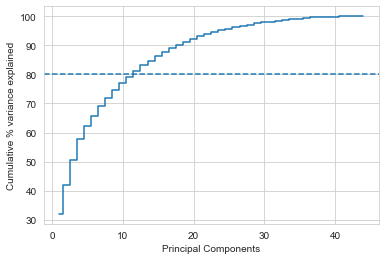

In [54]:
# 1️⃣ Fit PCA on the pre-processed data
X_prepared = preprocessor.fit_transform(df_km)
pca = PCA().fit(X_prepared)

# 2️⃣ Plot cumulative explained variance
plt.step(range(1, len(pca.explained_variance_ratio_)+1),
         np.cumsum(pca.explained_variance_ratio_)*100, where='mid')
plt.xlabel("Principal Components")
plt.ylabel("Cumulative % variance explained")
plt.axhline(80, ls='--')
plt.show()


In [55]:
loadings = pd.DataFrame(
    pca.components_.T,
    index = preprocessor.get_feature_names_out(),
    columns = [f'PC{i+1}' for i in range(pca.n_components_)]
)

# Show top ±5 strongest contributors for the first few PCs
for pc in loadings.columns[:5]:
    print(f"\n=== {pc} ===")
    print(loadings[pc].abs().sort_values(ascending=False).head(5))



=== PC1 ===
num__OWN_HOUSE      0.259392
num__DINK           0.256376
num__SINGLE         0.254222
num__EDU_LOW        0.233743
num__SHOP_ONLINE    0.233225
Name: PC1, dtype: float64

=== PC2 ===
num__LOAN              0.401665
num__FAM_CHILD_Y       0.352817
num__FAM_WCHILD_OLD    0.307177
num__FAM               0.279519
num__SHOP_ONLINE       0.224413
Name: PC2, dtype: float64

=== PC3 ===
num__CIT_HOUSEHOLD    0.366316
num__FAM              0.357938
num__FAM_CHILD_O      0.324970
num__EDU_LOW          0.294463
num__SINGLES_YOUNG    0.265712
Name: PC3, dtype: float64

=== PC4 ===
num__EDU_MID     0.476831
num__SOCCL_B1    0.381754
num__SOCCL_A     0.341212
num__EDU_HIGH    0.329752
num__SOCCL_B2    0.315690
Name: PC4, dtype: float64

=== PC5 ===
num__churn             0.685620
num__conv              0.669557
num__STAGE_OF_LIFE     0.129494
num__FAM_WCHILD_OLD    0.120455
num__FAM_WCHILD        0.119354
Name: PC5, dtype: float64


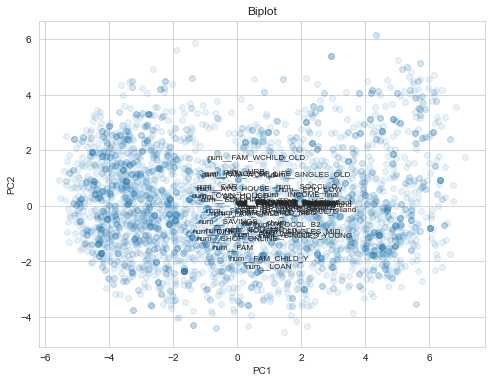

In [56]:
import matplotlib.patches as mpatches

pc1, pc2 = 0, 1
plt.figure(figsize=(8,6))
plt.scatter(pca.transform(X_prepared)[:, pc1], pca.transform(X_prepared)[:, pc2], alpha=.1)
for i, var in enumerate(loadings.index):
    plt.arrow(0,0, loadings.iloc[i, pc1]*5, loadings.iloc[i, pc2]*5,
              head_width=.2, alpha=.7)
    plt.text(loadings.iloc[i, pc1]*5*1.1, loadings.iloc[i, pc2]*5*1.1, var, fontsize=8)
plt.xlabel(f'PC{pc1+1}')
plt.ylabel(f'PC{pc2+1}')
plt.title("Biplot")
plt.show()

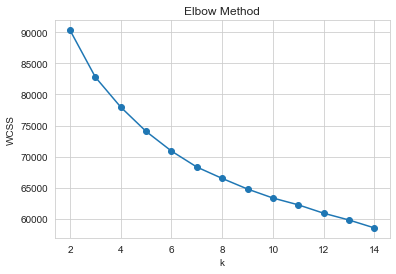

In [57]:
wcss = []                         # within-cluster sum of squares
K = range(2, 15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_prepared)
    wcss.append(km.inertia_)

plt.plot(K, wcss, marker='o')
plt.xlabel('k')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


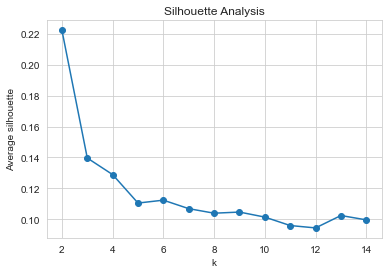

In [58]:
sil = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_prepared)
    sil.append(silhouette_score(X_prepared, labels))

plt.plot(K, sil, marker='o')
plt.xlabel('k')
plt.ylabel('Average silhouette')
plt.title('Silhouette Analysis')
plt.show()


In [59]:
opt_k = OptimalK(parallel_backend='joblib')   # uses 10 refs by default
n_clusters = opt_k(X_prepared, cluster_array=range(2, 15))
print(f"Optimal k by gap statistic: {n_clusters}")

Optimal k by gap statistic: 14


In [60]:
k_final = 5
n_pcs   = 12            # or whatever your elbow-cum-variance plot suggested

pipeline = Pipeline([
    ('prep', preprocessor),
    ('pca',  PCA(n_components=n_pcs, random_state=42)),   # comment out if you skip PCA
    ('km',   KMeans(n_clusters=k_final, random_state=42))
])

df_km['cluster'] = pipeline.fit_predict(df_km)

In [61]:
sizes = df_km['cluster'].value_counts().sort_index()
print(sizes)

cluster
0    636
1    978
2    708
3    697
4    632
Name: count, dtype: int64


In [62]:
centroids_pca = pipeline.named_steps['km'].cluster_centers_
centroids_pca = pd.DataFrame(centroids_pca,
                             columns=[f'PC{i+1}' for i in range(centroids_pca.shape[1])])

In [70]:
# 1. Inverse PCA
recon = pipeline.named_steps['pca'].inverse_transform(centroids_pca)

# 2. Inverse scaler + OHE
#    We need the ColumnTransformer to do the inverse transform—invert numeric scaler,
#    and invert dummy coding by taking highest-probability category for each PROVINCE dummy.
centroids_raw = pipeline.named_steps['prep'].inverse_transform(recon)
centroids_raw = pd.DataFrame(centroids_raw, columns = num_features + 
                             list(pipeline.named_steps['prep']
                                  .named_transformers_['cat']
                                  .get_feature_names_out(cat_features)))

AttributeError: 'ColumnTransformer' object has no attribute 'inverse_transform'

In [71]:
profile = df_km.groupby('cluster')[num_features].mean()
display(profile.style.background_gradient(axis=0))

ImportError: Pandas requires version '3.0.0' or newer of 'jinja2' (version '2.11.3' currently installed).

In [ ]:
pcs = pipeline.named_steps['pca'].transform(preprocessor.transform(df_km))
sns.scatterplot(x=pcs[:,0], y=pcs[:,1], hue=df_km['cluster'], palette='tab10', alpha=.5)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Cluster separation in PCA space')
plt.show()


In [ ]:
df_km.to_csv("customers_with_clusters.csv", index=False)

In [74]:
import pandas as pd

# 1. grab fitted steps
scaler = pipeline.named_steps['prep'] \
                .named_transformers_['num'] \
                .named_steps['scaler']
ohe    = pipeline.named_steps['prep'] \
                .named_transformers_['cat'] \
                .named_steps['ohe']
pca    = pipeline.named_steps['pca']
km     = pipeline.named_steps['km']

# 2. get cluster centers in PCA space
centroids_pca = km.cluster_centers_

# 3. inverse‐PCA → back to scaled & one-hot space
centroids_preproc = pca.inverse_transform(centroids_pca)

# 4. split numeric vs encoded parts
n_num = len(num_features)
num_scaled = centroids_preproc[:, :n_num]
cat_encoded = centroids_preproc[:, n_num:]

# 5. inverse‐scale numerics → original units
num_orig = scaler.inverse_transform(num_scaled)

# 6. inverse‐encode categoricals → original PROVINCE values
#    Note: result is shape (n_clusters, 1)
province_orig = ohe.inverse_transform(cat_encoded).ravel()

# 7. assemble into a DataFrame
centroids_df = pd.DataFrame(num_orig, columns=num_features)
centroids_df['PROVINCE'] = province_orig

# 8. round for readability
centroids_df[num_features] = centroids_df[num_features].round(2)

print("Cluster centers back in original feature space:")
print(centroids_df)


Cluster centers back in original feature space:
    URB  INCOME_final  SOCCL_A  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  \
0  3.67          2.13     4.41      2.19      1.54     1.12     1.04   
1  4.68          2.99     2.16      3.52      2.50     1.35     1.23   
2  3.02          4.06     1.06      1.31      2.36     2.93     3.02   
3  3.97          3.56     1.14      1.82      3.41     2.32     2.13   
4  2.68          2.74     2.07      2.83      2.91     1.69     1.16   

   EDU_HIGH  EDU_MID  EDU_LOW  ...  FAM_WCHILD_MED  FAM_WCHILD_OLD  \
0      4.52     2.05     1.41  ...            2.27            3.19   
1      2.26     4.08     2.10  ...            2.35            3.47   
2      1.34     2.35     4.30  ...            1.60            1.89   
3      1.32     2.57     4.31  ...            1.74            2.58   
4      2.49     3.92     1.84  ...            2.09            2.21   

   CIT_HOUSEHOLD  LOAN  SAVINGS  SHOP_ONLINE   CAR  conv  churn       PROVINCE  
0           4.66 